## EDA
### 라이브러리

In [8]:
import os
import json
from glob import glob

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from shapely.geometry import Polygon
import cv2
import numpy as np


### 경로

In [2]:
image_dir = "../data/train/DCM"
json_dir = "../data/train/outputs_json" 

### Class 분포
#### - Class별 개수

Text(0, 0.5, 'Count')

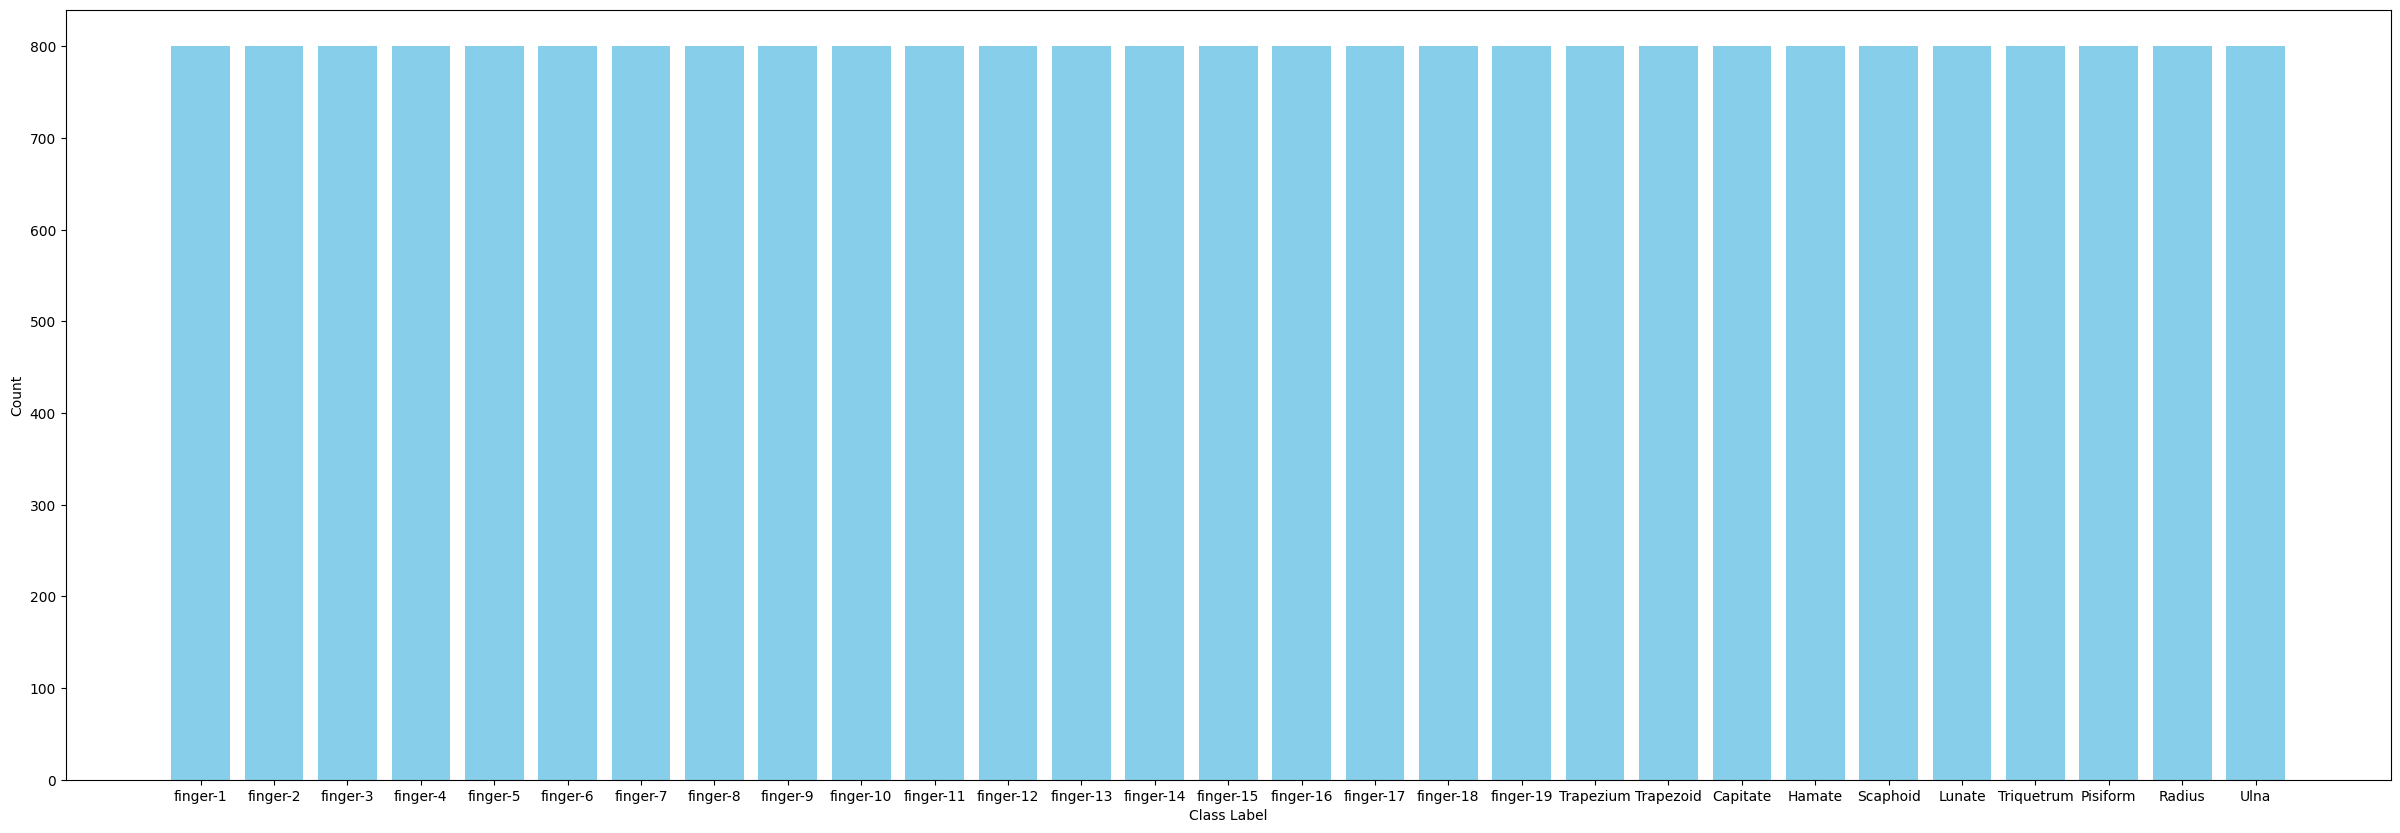

In [3]:
label_counts = Counter()

for json_file in glob(os.path.join(json_dir, "**", "*.json"), recursive=True):
    with open(json_file, "r", encoding="utf-8") as file:
        data = json.load(file)
        label_counts.update(annotation['label'] for annotation in data['annotations'])

plt.figure(figsize=(30, 10))
plt.bar(label_counts.keys(), label_counts.values(), color="skyblue")
plt.xlabel("Class Label")
plt.ylabel("Count")


#### - Class별 pixel 차지 비율

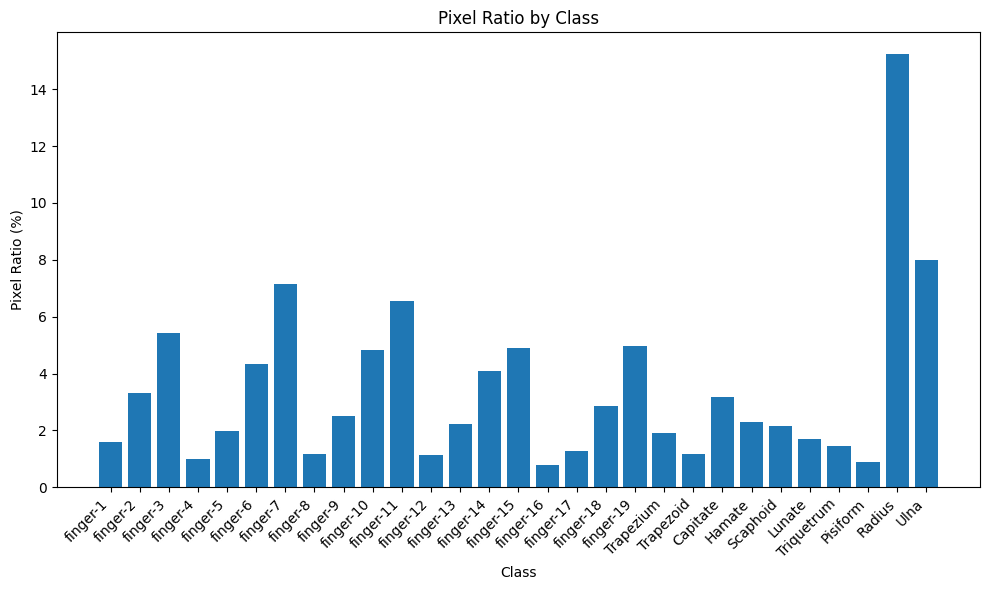

In [4]:
json_files = glob(os.path.join(json_dir, 'ID*', '*.json'))

label_pixel_counts = defaultdict(float)

for json_file in json_files:
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    image_width = data['metadata']['width']
    image_height = data['metadata']['height']
    total_pixels = image_width * image_height

    for annotation in data['annotations']:
        label = annotation['label']
        points = annotation['points']

        polygon = Polygon(points)
        area = polygon.area

        label_pixel_counts[label] += area

total_area = sum(label_pixel_counts.values())

label_pixel_ratios = {label: (count / total_area) * 100 for label, count in label_pixel_counts.items()}

labels = list(label_pixel_ratios.keys())
ratios = list(label_pixel_ratios.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, ratios)
plt.xlabel('Class')
plt.ylabel('Pixel Ratio (%)')
plt.title('Pixel Ratio by Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### - 이미지 당 29개의 클래스 유무 확인

### Metadata 분포
#### - 나이, 성별, 몸무게, 키 분포

In [ ]:
csv_path = "../data/meta_data.csv"
meta_data = pd.read_csv(csv_path)

meta_data.columns = ['Id', 'Age', 'Gender', 'Weight', 'Height', 'Extra']
meta_data = meta_data.replace({'Gender' : '남'}, 'Male')
meta_data = meta_data.replace({'Gender' : '여'}, 'Female')

plt.figure(figsize=(12, 10))

# 나이 분포
plt.subplot(2, 2, 1)
sns.histplot(meta_data['Age'], bins=10, kde=True, color="skyblue")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")

# 성별 분포
plt.subplot(2, 2, 2)
sns.countplot(x='Gender', data=meta_data, hue='Gender', palette="Set2", legend=False)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")

# 몸무게 분포
plt.subplot(2, 2, 3)
sns.histplot(meta_data['Weight'], bins=10, kde=True, color="lightgreen")
plt.title("Weight Distribution")
plt.xlabel("Weight (kg)")
plt.ylabel("Frequency")

# 키 분포
plt.subplot(2, 2, 4)
sns.histplot(meta_data['Height'], bins=10, kde=True, color="salmon")
plt.title("Height Distribution")
plt.xlabel("Height (cm)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

#### - 성별에 따른 나이, 몸무게, 키 분포

In [ ]:
plt.figure(figsize=(18, 5))

# 성별에 따른 나이 분포
plt.subplot(1, 3, 1)
sns.histplot(data=meta_data, x="Age", hue="Gender", bins=10, kde=True, palette="Set2")
plt.title("Age Distribution by Gender")

# 성별에 따른 몸무게 분포
plt.subplot(1, 3, 2)
sns.histplot(data=meta_data, x="Weight", hue="Gender", bins=10, kde=True, palette="Set2")
plt.title("Weight Distribution by Gender")

# 성별에 따른 키 분포
plt.subplot(1, 3, 3)
sns.histplot(data=meta_data, x="Height", hue="Gender", bins=10, kde=True, palette="Set2")
plt.title("Height Distribution by Gender")

plt.tight_layout()
plt.show()

#### - Metadate, train 데이터 join

In [9]:
IMAGE_ROOT = "../data/train/DCM"
LABEL_ROOT = "../data/train/outputs_json"

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}


pngs = sorted(pngs)
jsons = sorted(jsons)
file_names = {json_file[:-5] for json_file in jsons}

# metadata 엑셀
df = pd.read_excel("../data/meta_data.xlsx")
train_id_list = set()
for path in jsons:
    id = int(path[2:5])
    train_id_list.add(id)
train_df = df[df["ID"].isin(train_id_list)]

brightness = dict()
areas = dict()

def calculate_brightness(image, points):
    # 1. 이미지 읽기
    
    if image is None:
        raise ValueError("Image not found or unable to load!")
    
    # 2. 다각형 마스크 생성
    mask = np.zeros_like(image, dtype=np.uint8) 
    points = np.array(points, dtype=np.int32)    
    cv2.fillPoly(mask, [points], 255)            

    # 3. 다각형 내부 픽셀 추출
    masked_pixels = cv2.bitwise_and(image, image, mask=mask)

    # 4. 밝기 계산
    brightness = cv2.mean(masked_pixels, mask=mask)[0]
    return brightness

def calculate_polygon_area(points):
    points = np.array(points)
    x = points[:, 0]
    y = points[:, 1]
    
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    return area

# 밝기 정보와 면적 정보 추출
for path in file_names:
    brightness[path] = []
    areas[path] = []
    image_path = os.path.join(IMAGE_ROOT, path) + ".png"
    json_path  = os.path.join(LABEL_ROOT, path) + ".json"
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    with open(json_path) as json_file:
        anns = json.load(json_file)["annotations"]
        #print("file:", json_path)

        for class_id, ann in enumerate(anns):
            total = 0
            points = ann["points"]
            for (x, y) in points:
                total += gray_image[y][x]
            avg = total / len(points)
            brightness[path].append(calculate_brightness(gray_image, points))
            areas[path].append(calculate_polygon_area(points))
            #print(f"class: {i} / points_count: {len(points)}")

brightness_df = defaultdict(lambda: [0] * 29)
area_df = defaultdict(lambda: [0] * 29)

for file_path, lst in brightness.items():
    id = int(file_path[2:5])
    for i in range(len(lst)):
        brightness_df[id][i] += lst[i]/2

for file_path, lst in areas.items():
    id = int(file_path[2:5])
    for i in range(len(lst)):
        area_df[id][i] += lst[i]

brightness_df = pd.DataFrame(brightness_df).T
brightness_df = brightness_df.reset_index()
brightness_df = brightness_df.rename(columns={'index': 'ID'})  # 기존 인덱스를 'ID'로 이름 변경

area_df = pd.DataFrame(area_df).T
area_df = area_df.reset_index()
area_df = area_df.rename(columns={'index': 'ID'})  # 기존 인덱스를 'ID'로 이름 변경

#### - 나이에 따른 뼈의 밀도 분포

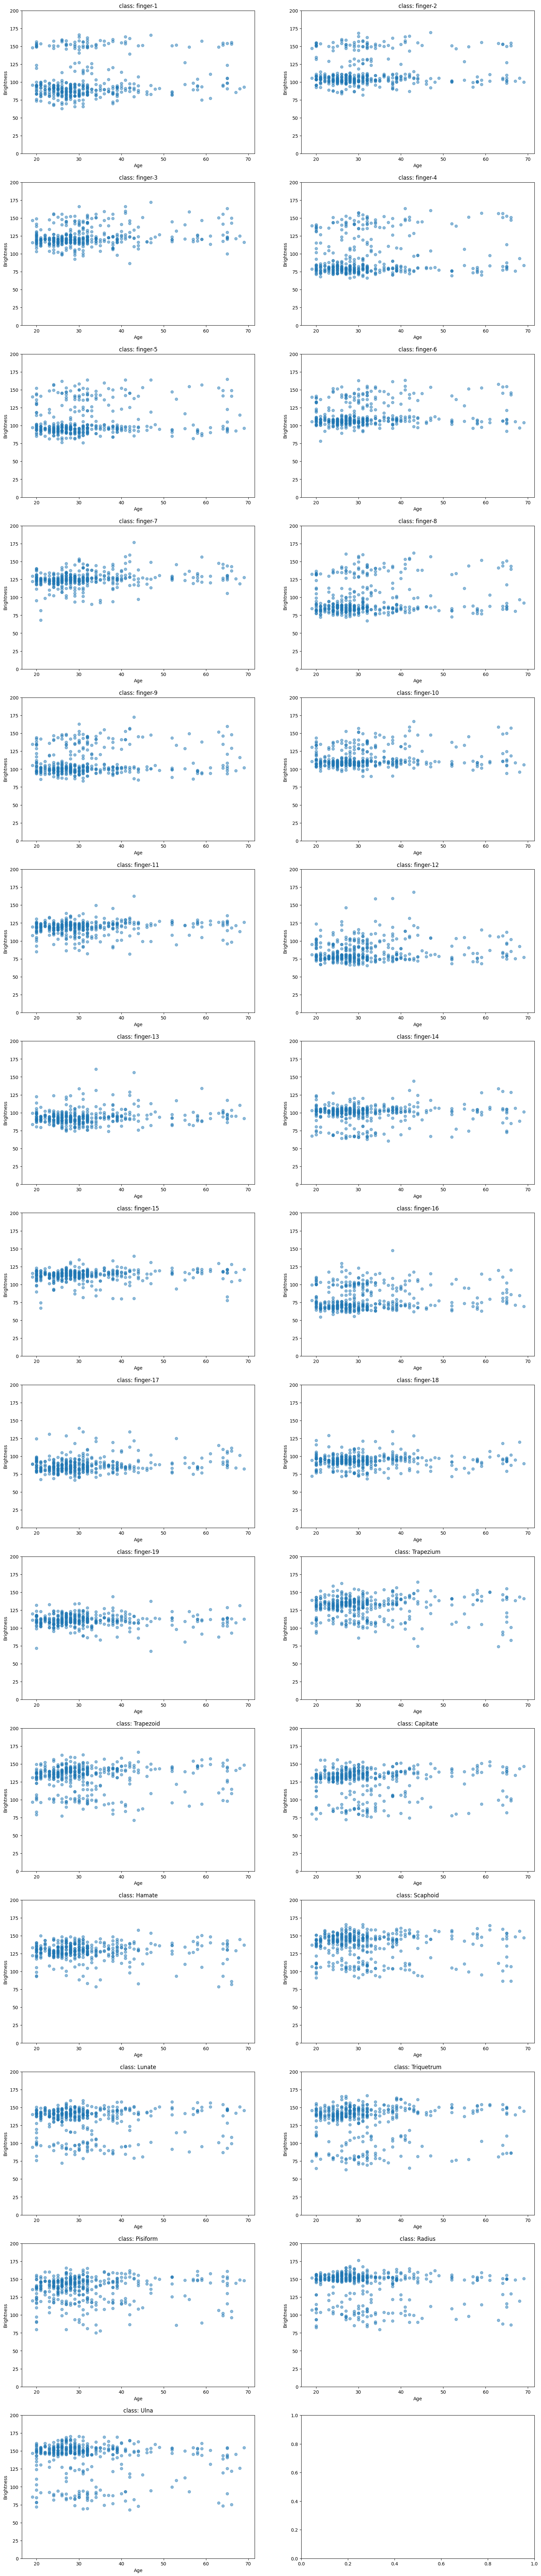

In [10]:
final_df = pd.merge(brightness_df, train_df, on="ID", how="inner")
final_df["total"] = final_df.loc[:, 0:28].mean(axis=1)
man_list = ['_x0008_남', '남', ' 남']
final_df["성별"] = np.where(final_df["성별"].isin(man_list), "남자", "여자")

fig, axes = plt.subplots(15, 2, figsize=(20, 100))
for i in range(29):
    axes[i//2][i%2].set_title(f"class: {CLASSES[i]}")
    axes[i//2][i%2].set_ylim(0, 200)
    axes[i//2][i%2].scatter(final_df["나이"], final_df[i], alpha=0.5)
    axes[i//2][i%2].set_xlabel("Age")
    axes[i//2][i%2].set_ylabel("Brightness")
plt.show()

#### - 성별에 따른 뼈 밀도 분포

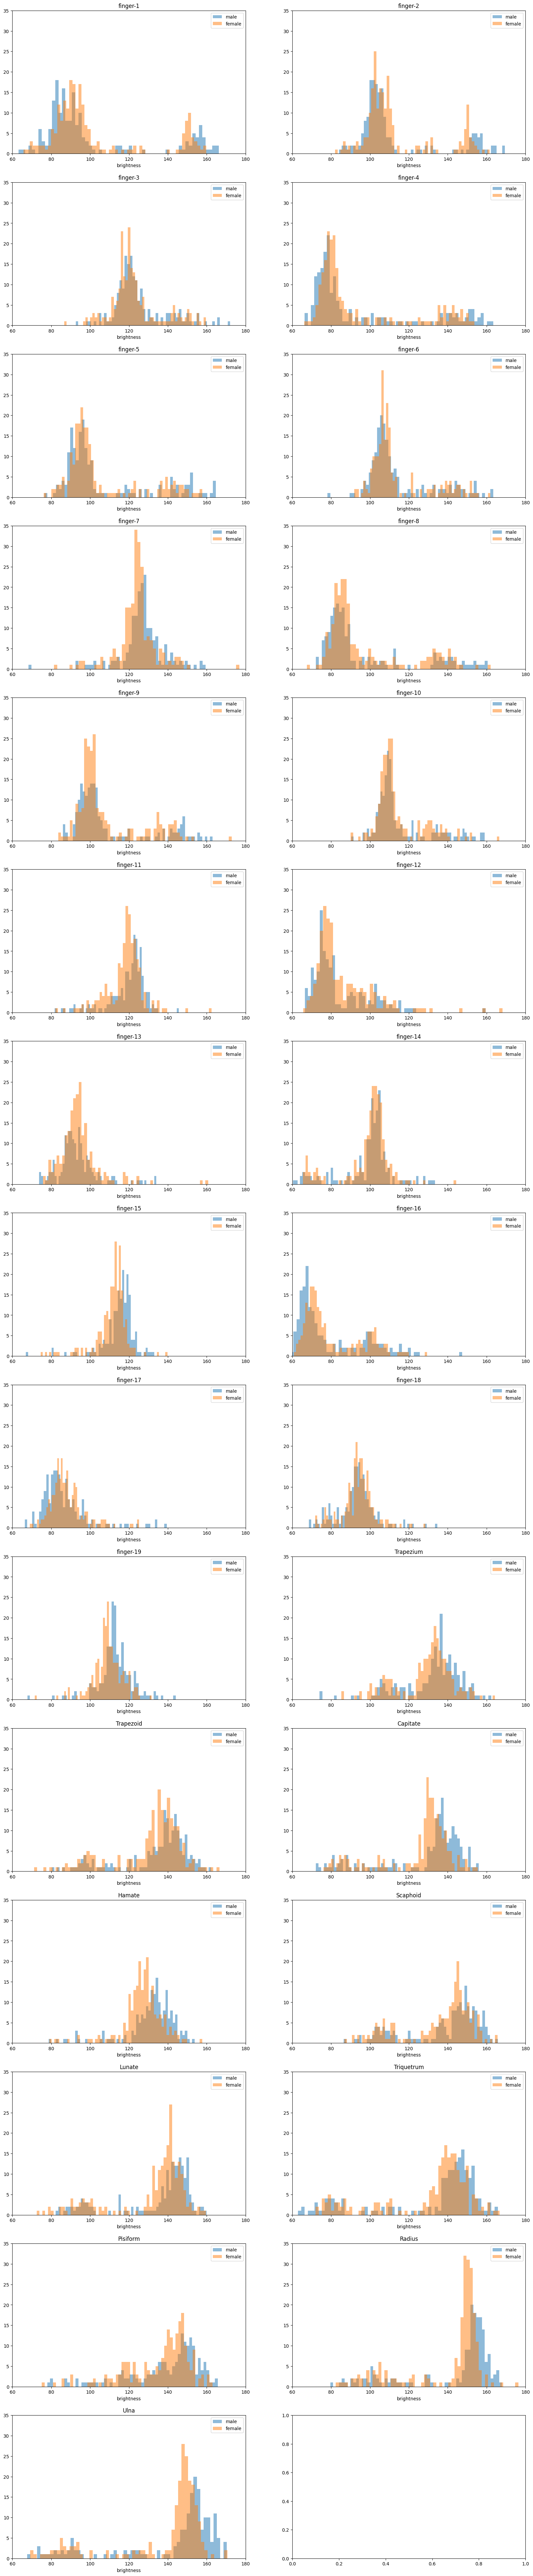

In [11]:
fig, axes = plt.subplots(15, 2, figsize=(20, 100))

for i in range(29):
    for gender in ["남자", "여자"]:
        gender_df = final_df[final_df["성별"]==gender]
        axes[i//2][i%2].hist(gender_df[i], alpha=0.5, label="male" if gender=="남자" else "female", bins=60)
        axes[i//2][i%2].set_title(f"{CLASSES[i]}")
        axes[i//2][i%2].set_xlim(60, 180)
        axes[i//2][i%2].set_ylim(0, 35)
        axes[i//2][i%2].legend()
        axes[i//2][i%2].set_xlabel("brightness")
plt.show()

#### - 키에 따른 뼈 면적 분포

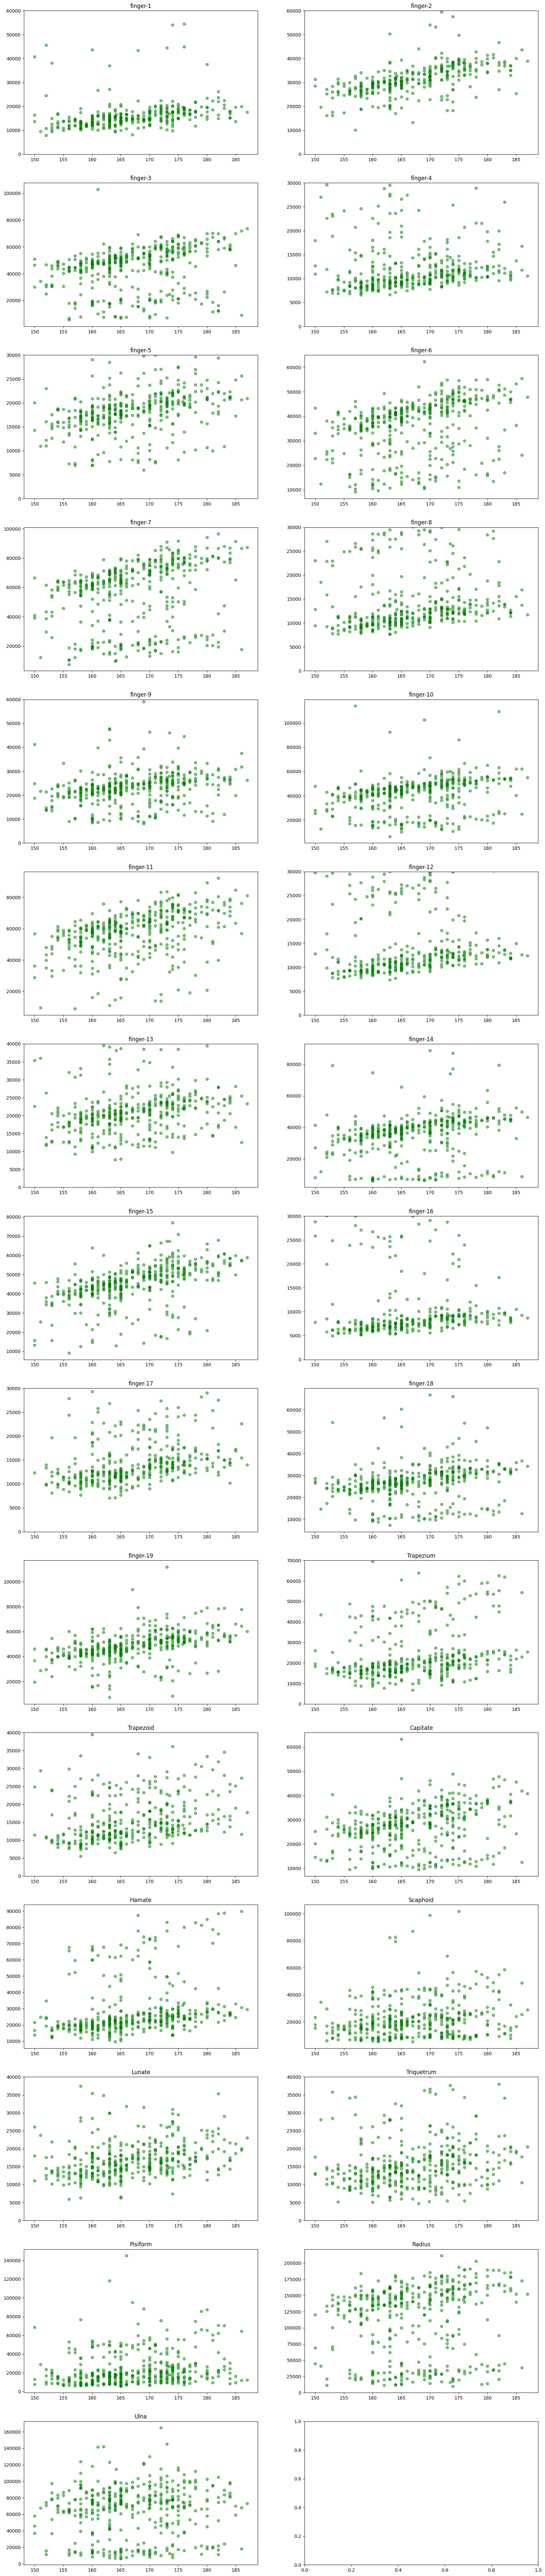

In [12]:
area_merge = pd.merge(area_df, train_df, on="ID", how="inner")

fig, axes = plt.subplots(15, 2, figsize=(20, 100))
for i in range(29):
    axes[i//2][i%2].scatter(area_merge["키(신장)"], area_merge[i], alpha=0.5, color="green")
    axes[i//2][i%2].set_title(f"{CLASSES[i]}")
    if i == 0 or i == 1 or i==8:
        axes[i//2][i%2].set_ylim(0, 60000)
    elif i == 3 or i==4 or i==7 or i==11 or i ==15 or i==16:
        axes[i//2][i%2].set_ylim(0, 30000)
    elif i==19:
        axes[i//2][i%2].set_ylim(0, 70000)
    elif i==12 or i==20 or i==24 or i==25:
        axes[i//2][i%2].set_ylim(0, 40000)
plt.show()